### Packages

In [20]:
# Basic Packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import datetime as dt


In [44]:
# Model based Packages
import sklearn
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import  RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score

In [2]:
warnings.filterwarnings('ignore')

 encoding is used as the encryption type 

### Data

In [3]:
data = pd.read_csv('Ecommerce_data.csv',encoding='unicode_escape',
                   header=0,
                   parse_dates=['InvoiceDate'],
                   infer_datetime_format=True)

In [4]:
data.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


In [5]:
data['CustomerID'] = data['CustomerID'].astype('str')

In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    541909 non-null  object        
 1   StockCode    541909 non-null  object        
 2   Description  540455 non-null  object        
 3   Quantity     541909 non-null  int64         
 4   InvoiceDate  541909 non-null  datetime64[ns]
 5   UnitPrice    541909 non-null  float64       
 6   CustomerID   541909 non-null  object        
 7   Country      541909 non-null  object        
dtypes: datetime64[ns](1), float64(1), int64(1), object(5)
memory usage: 33.1+ MB


### EDA

<Axes: xlabel='Products', ylabel='Count'>

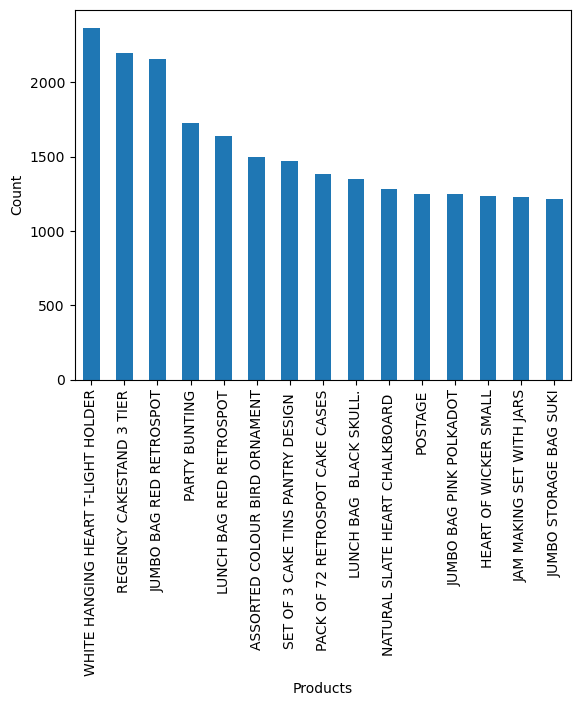

In [7]:
data['Description'].value_counts().sort_values(ascending=False).iloc[0:15].plot(kind='bar',
                                                                                xlabel='Products',
                                                                                ylabel='Count')

In [8]:
data.groupby(['CustomerID','InvoiceNo','Country']).Quantity.count().sort_values(ascending=False)

CustomerID  InvoiceNo  Country       
nan         573585     United Kingdom    1114
            581219     United Kingdom     749
            581492     United Kingdom     731
            580729     United Kingdom     721
            558475     United Kingdom     705
                                         ... 
16365.0     559822     United Kingdom       1
            539033     United Kingdom       1
16362.0     C566966    United Kingdom       1
16359.0     C555267    United Kingdom       1
nan         C580605    United Kingdom       1
Name: Quantity, Length: 25900, dtype: int64

In [9]:
data.isnull().sum()

InvoiceNo         0
StockCode         0
Description    1454
Quantity          0
InvoiceDate       0
UnitPrice         0
CustomerID        0
Country           0
dtype: int64

### Data Preprocessing

In [11]:
data  = data[data['Quantity']>0]

In [12]:
data = data[~data['InvoiceNo'].str.contains('C',na=False)]

In [13]:
data.dropna(inplace=True)

In [14]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 530693 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    530693 non-null  object        
 1   StockCode    530693 non-null  object        
 2   Description  530693 non-null  object        
 3   Quantity     530693 non-null  int64         
 4   InvoiceDate  530693 non-null  datetime64[ns]
 5   UnitPrice    530693 non-null  float64       
 6   CustomerID   530693 non-null  object        
 7   Country      530693 non-null  object        
dtypes: datetime64[ns](1), float64(1), int64(1), object(5)
memory usage: 36.4+ MB


In [15]:
data['TotalPrice'] = data['Quantity']*data['UnitPrice']

### RFM Analysis
RFM stands for Recency, Frequency and Monetary value, each corresponding to some key customer trait. These RFM metrics are important indicators of a customer's behavior because frequency and monetary value affects a customer's lifetime value and recency affects retention, measure of engagement

RFM factors illustrate theses facts :
- The more recent the purchase, the more responsive the customer is to promotions
- The more frequently the customer buys, the more engaged and satisfied they are
- Monetary value differentiates heavy spenders from low value purchases

In [16]:
data.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,TotalPrice
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom,15.30
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom,22.00
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34


In [21]:
today_date = dt.datetime(2011,12,11)

In [22]:
rfm = data.groupby('CustomerID').agg({
    # Days since most recent purchase
    'InvoiceDate' : lambda x : (today_date-x.max()).days,
    # No. of unique invoices
    'InvoiceNo' : lambda x : x.nunique(),
    # Total amount spent
    'TotalPrice' : lambda x : x.sum()   
})
rfm.columns = (['Recency','Frequency','Monetary'])

rfm[rfm['Monetary']>0]

rfm = rfm.reset_index()

#### RFM Score

In [24]:
def rfm_scores(dataframe):
    df = dataframe.copy()
    
    df['Recency_Score'] = pd.qcut(df['Recency'].rank(method='first'),5,labels=[5,4,3,2,1]).astype(int)
    
    df['Frequency_Score'] = pd.qcut(df['Frequency'].rank(method='first'),5,labels=[1,2,3,4,5]).astype(int)
    
    df['Monetary_Score'] = pd.qcut(df['Monetary'].rank(method='first'),5,labels=[1,2,3,4,5]).astype(int)
    
    df['RFM_Score'] = df['Recency_Score'].astype(str) + df['Frequency_Score'].astype(str) + df['Monetary_Score'].astype(str)
    
    return df

In [25]:
RFM_Scores = rfm_scores(rfm)

In [26]:
RFM_Scores

,CustomerID,Recency,Frequency,Monetary,Recency_Score,Frequency_Score,Monetary_Score,RFM_Score
0,12346.0,326,1,77183.60,1,1,5,115
1,12347.0,3,7,4310.00,5,5,5,555
2,12348.0,76,4,1797.24,2,4,4,244
3,12349.0,19,1,1757.55,4,1,4,414
4,12350.0,311,1,334.40,1,1,2,112
...,...,...,...,...,...,...,...,...
4335,18281.0,181,1,80.82,1,2,1,121
4336,18282.0,8,2,178.05,5,3,1,531
4337,18283.0,4,16,2094.88,5,5,5,555
4338,18287.0,43,3,1837.28,3,4,4,344


### Segmentation

In [28]:
seg_map = {r'[4-5][4-5][4-5]' : 'Best',
           r'[3-5]5[2-5]' : 'Faithful',
           r'[2-5][2-5]5' : 'Highest_Paying',
           r'[3-5][3-5][1-5]' : 'Most_Loyal',
           r'333' : 'Needs_Attention',
           r'[2-4][2-4][1.5]' : 'Good',
           r'[1-5][1-5][1-5]' : 'Average'
}

RFM_Scores['Segment'] = RFM_Scores['RFM_Score'].replace(seg_map,regex=True)

In [29]:
RFM_Scores.head()

,CustomerID,Recency,Frequency,Monetary,Recency_Score,Frequency_Score,Monetary_Score,RFM_Score,Segment
0,12346.0,326,1,77183.60,1,1,5,115,Average
1,12347.0,3,7,4310.00,5,5,5,555,Best
2,12348.0,76,4,1797.24,2,4,4,244,Average
3,12349.0,19,1,1757.55,4,1,4,414,Average
4,12350.0,311,1,334.40,1,1,2,112,Average


<Axes: xlabel='Segments', ylabel='Count'>

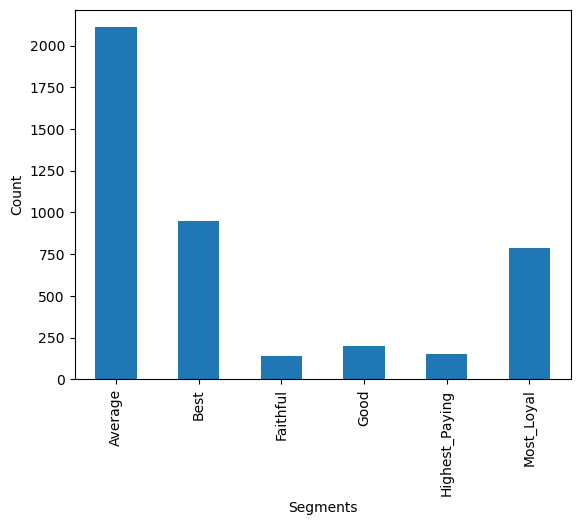

In [40]:
RFM_Scores.groupby('Segment').CustomerID.count().plot(kind='bar',
                                                      xlabel='Segments',
                                                      ylabel='Count')

### Segmentation Model

In [45]:
rfm_df = rfm[['Recency','Frequency','Monetary']]

scaler = StandardScaler()

rfm_df_scaled = scaler.fit_transform(rfm_df)

In [46]:
kmeans = KMeans(n_clusters=6,max_iter=100)
kmeans.fit(rfm_df_scaled)

KMeans(max_iter=100, n_clusters=6)

In [47]:
rfm_kmeans = rfm.copy()
rfm_kmeans['ClusterID'] = (kmeans.labels_).astype('str')

In [48]:
rfm_kmeans

,CustomerID,Recency,Frequency,Monetary,ClusterID
0,12346.0,326,1,77183.60,5
1,12347.0,3,7,4310.00,0
2,12348.0,76,4,1797.24,3
3,12349.0,19,1,1757.55,0
4,12350.0,311,1,334.40,5
...,...,...,...,...,...
4335,18281.0,181,1,80.82,2
4336,18282.0,8,2,178.05,0
4337,18283.0,4,16,2094.88,0
4338,18287.0,43,3,1837.28,0


### Classification

In [50]:
x = RFM_Scores.drop(['CustomerID','Segment'],axis=1)
y = RFM_Scores['Segment']

In [51]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=43)

#### Logistic Regression with HyperParameter Tuning

In [52]:
# HyperParameter Tuning
parameters = {'max_iter' : [1000,1500,2000,3000,5000]}

lr_classifier = LogisticRegression()
lr_classifier_rs = RandomizedSearchCV(estimator = lr_classifier, param_distributions = parameters,
                                      cv = 5, random_state = 43 , verbose = 1)

In [54]:
lr_classifier_rs.fit(x_train,y_train)

Fitting 5 folds for each of 5 candidates, totalling 25 fits


RandomizedSearchCV(cv=5, estimator=LogisticRegression(),
                   param_distributions={'max_iter': [1000, 1500, 2000, 3000,
                                                     5000]},
                   random_state=43, verbose=1)

In [55]:
print('Best Estimator : ', lr_classifier_rs.best_estimator_)
print('Best Parameters : ', lr_classifier_rs.best_params_)
print('Best Score : ', lr_classifier_rs.best_score_)

Best Estimator :  LogisticRegression(max_iter=5000)
Best Parameters :  {'max_iter': 5000}
Best Score :  0.8610855805081071


In [58]:
y_pred_lr = lr_classifier_rs.predict(x_test)

In [60]:
lr_accuracy = accuracy_score(y_true=y_test,y_pred=y_pred_lr)
print('Accuracy', lr_accuracy)

Accuracy 0.8609831029185868


In [62]:
cm = confusion_matrix(y_test.values,y_pred_lr)
cm

array([[582,   0,   2,   8,  11,  23],
       [  0, 276,   0,   0,   0,  18],
       [  0,  15,  22,   0,   4,   5],
       [ 38,   0,   0,  29,   0,   1],
       [  8,   3,   2,   0,  25,   0],
       [ 24,   8,   5,   5,   1, 187]], dtype=int64)